<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/06_%5BCV%5D_data_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Machine Learning Model: image segmentation**

| | |
|------|------|
| Filename | 06_[CV]_data_segmentation.ipynb |
| Author(s) | Benjamin (contact.upside830@silomails.com) |
| Date | January 7, 2024 |
| Aim(s) | Identify automatically and delineate objects |
| Dataset(s) | Brain Tumor Image DataSet [[1]](https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation)|
| Version | Python 3.10.12 - TensorFlow 2.17.1 - final notebook version |


<br> **!!Read before running!!** <br>
* **Step 1.** Fill in the inputs.
* **Step 2.** GPU execution is recommended for training. Yet, a pre-trained model can be used by running this notebook on a CPU. Using a pre-trained model saves time, computer resources and CO2 emissions.
* **Step 3.** Run all and read comments.

---

#### **Motivation**

A semantic segmentation model for tumor detection is developped in this notebook by using the `Brain Tumor Image` database. The model assigns a class to each pixel in the medical image - pixel belonging to a tumor area or a healthy area. A mask is then built to group the pixels according to their class, making it possible to correctly visualize the model's predictions.

#### **Outline**

* Input section
* Python librairies & display utilities
* Load & Process Data
* Model & training
* Evaluation & predictions
* References

---

## **0. Input section**

In [1]:
epochs = 30 # epoch number (see section 3.4)
num_samples = 5 # prediction number (see section 4.2)

---

## **1. Python libraries & display utilities**

In [2]:
# @title 1.1. Python libraries [RUN ME]

! pip install -q tensorflow-model-optimization

"""math"""
import numpy as np # linear algebra
import random

"""data importation and format"""
from os.path import join, getsize # join path segments
from pycocotools.coco import COCO # Python API that assists in loading, parsing and visualizing the annotations in COCO
import kagglehub

"""ML models"""
import tensorflow as tf # framework for ML/DL
import tensorflow_model_optimization as tfmot # model optimization
from tensorflow_model_optimization.python.core.keras.compat import keras #

"""display"""
import matplotlib.pyplot as plt # graphing package
from PIL import Image # image processing capabilities

"""performances"""
from time import time # timer
start = time()
device = tf.config.list_physical_devices(device_type=None)[-1][-1]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 13.3 MB/s eta 0:00:00


In [3]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and import files (see section 3.2)"""
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata # clone TensorFlow repertory
  training_curves = Image.open("TensorFlow_duplicata/99_pre_trained_models/06_data_segmentation/results_graph.jpeg")
  !rm -rf TensorFlow_duplicata/ # delete the cloned repertory
  return training_curves

In [4]:
# @title 1.3. Figure plots [RUN ME]

"""plot image + mask"""
def plot_image_mask(dataset, nb=5):
  for i, (image, mask) in enumerate(dataset.take(nb)):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy())
    plt.title("Image"), plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.numpy().squeeze(), cmap="gray")
    plt.title("Mask"), plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image.numpy())
    plt.imshow(mask.numpy().squeeze(), cmap="Oranges", alpha=0.4)
    plt.title("Image + Mask"), plt.axis("off")

    plt.show()

"""plot training curves for the training and validation set"""
def plot_evolution(history):
  plt.figure(figsize=(18,5))
  plt.subplot(1,3,1) # Loss graph
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.title('Model Loss'), plt.xlabel('Epoch'), plt.ylabel('Loss'), plt.legend()

  plt.subplot(1,3,2) # Accuracy graph
  plt.plot(history['accuracy'], label='Training Accuracy')
  plt.plot(history['val_accuracy'], label='Validation Accuracy')
  plt.title('Model Accuracy'), plt.xlabel('Epoch'), plt.ylabel('Accuracy'), plt.legend()

  plt.subplot(1,3,3) # Dice coeff graph
  plt.plot(history['dice_coef'], label='Training Dice')
  plt.plot(history['val_dice_coef'], label='Validation Dice')
  plt.title('Model Dice coeff'), plt.xlabel('Epoch'), plt.ylabel('Dice coeff'), plt.legend()

  plt.tight_layout()
  plt.show()

"""plot prediction + mask"""
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
  random_batch = random.choice(list(dataset)) # random batch
  images, masks = random_batch

  indices = random.sample(range(len(images)), min(num_samples, len(images))) # select random indices for num_samples
  predictions = model.predict(images)

  binary_predictions = (predictions > threshold).astype('uint8') # binarizing prediction masks

  for i in indices:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1) # original image
    plt.imshow(images[i])
    plt.title('Original Image'), plt.axis('off')

    plt.subplot(1, 3, 2) # true mask
    plt.imshow(images[i])
    plt.imshow(masks[i].numpy().squeeze(), cmap='Reds', alpha=0.4)
    plt.title('True Mask'), plt.axis('off')

    plt.subplot(1, 3, 3) # predicted mask
    plt.imshow(images[i])
    plt.imshow(binary_predictions[i].squeeze(), cmap='Oranges', alpha=0.4)
    plt.title('Predicted Mask'), plt.axis('off')

    plt.show()

---


## **2. Load & Process Data**

### 2.1. Retrieve data

The dataset distribution is already done: 70% for training (1502), 20% for validation (429) and 10% for test (215). The structure is as follows:
*   train
    *   _annotations.coco.json
    *   image_1.jpg
    *   image_2.jpg
    *   [...]
*   valid
    * _annotations.coco.json
    * image_1.jpg
    * [...]
*   test
    * [...]

Labels are provided by a coco.JSON file [[2]](https://roboflow.com/formats/coco-json). Each image and label is associated with a unique index. The area of interest - where the tumor is located - is indicated by a rectangle, 2 of whose vertices are given by the annotation file.



In [5]:
path = kagglehub.dataset_download("pkdarabi/brain-tumor-image-dataset-semantic-segmentation")

train_dir = path + '/train'
val_dir = path + '/valid'
test_dir = path + '/test'

train_annotation_file = train_dir + '/_annotations.coco.json'
val_annotation_file = val_dir + '/_annotations.coco.json'
test_annotation_file = test_dir + '/_annotations.coco.json'

train_coco = COCO(train_annotation_file) # initialize COCO API for train annotations
val_coco = COCO(val_annotation_file)
test_coco = COCO(test_annotation_file)

100%|██████████| 83.7M/83.7M [00:01<00:00, 74.4MB/s]

Extracting files...


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Two essential functions for data acquisition and mask creation:
*   `load_image_and_mask`: use an index `index` to load a medical image (feature) and a mask (label) from the annotation file `coco`. An initial black mask is created and then updated with the rectangle position given by `coco`.
*    `create_tf_dataset`: use `load_image_and_mask` as a generator function, apply it to all elements of the file and then create a tf dataset.

In [6]:
def load_image_and_mask(coco_file, image_dir, index):
  image_info = coco_file.loadImgs(index)[0] # get image info from an image index
  image_path = join(image_dir, image_info['file_name']) # retrieve image path from the image info

  image = Image.open(image_path) # loading image
  image = np.array(image)

  anns = coco_file.loadAnns(index) # get the instance annotation of index
  mask = np.zeros((image_info['height'], image_info['width'])) # initial mask
  for ann in anns:
      mask = np.maximum(mask, coco_file.annToMask(ann)) # creation of annotation zone

  return image, mask

In [7]:
def create_tf_dataset(coco, image_dir, image_ids):
  def generator():
        for image_id in image_ids:
            yield load_image_and_mask(coco, image_dir, image_id)

  return tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(None, None, 3)), tf.TensorSpec(shape=(None, None))))

In [8]:
train_dataset = create_tf_dataset(train_coco, train_dir, train_coco.getImgIds())
val_dataset = create_tf_dataset(val_coco, val_dir, val_coco.getImgIds())
test_dataset = create_tf_dataset(test_coco, test_dir, test_coco.getImgIds())

### 2.2. Pre-processing

Features are resized and standardized. No need pre-processing on masks except sizing transformations. The image size is set to 2^8 = 256 in order to have a multiple of 2 at each convolution layer output.  

In [9]:
def preprocess(image, mask):
  image = tf.image.resize(image, (256, 256))
  image = tf.cast(image, tf.float32) / 255.0

  mask = tf.expand_dims(mask, axis=-1)
  mask = tf.image.resize(mask, (256, 256)) # adding a channel size to a mask
  mask = tf.cast(mask, tf.float32)

  return image, mask

In [10]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

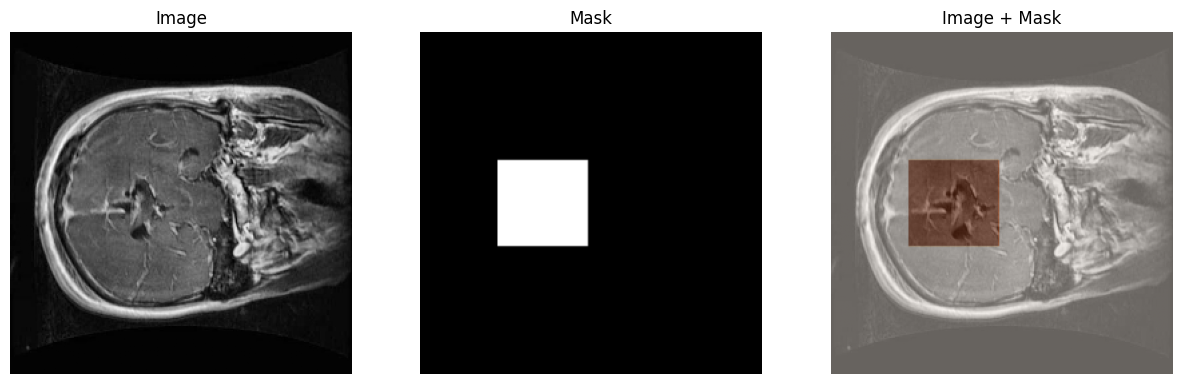

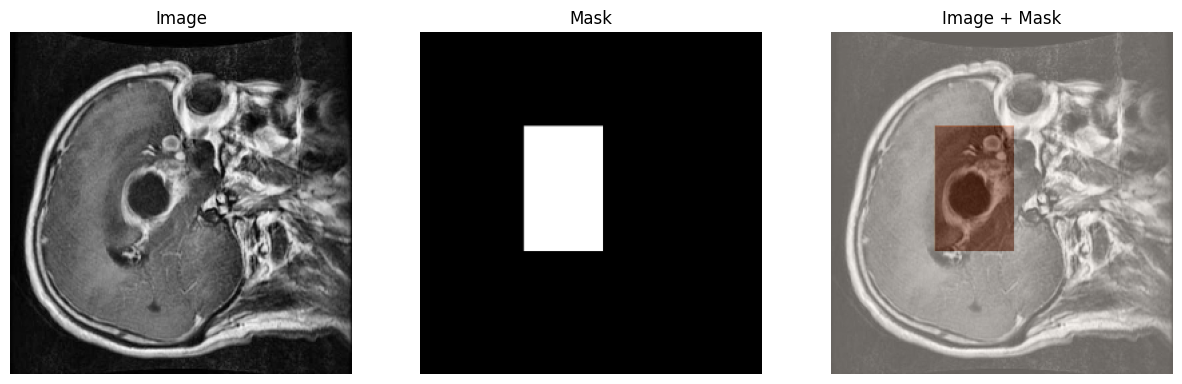

In [11]:
plot_image_mask(train_dataset, 2)

### 2.3. Batch generation and performances

In [12]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().repeat().batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().batch(batch_size).prefetch(buffer_size=AUTOTUNE)

steps_per_epoch = len(train_coco.getImgIds()) // batch_size
validation_steps = len(val_coco.getImgIds()) // batch_size
test_steps = len(test_coco.getImgIds()) // batch_size

---


## **3. Model and training**

### 3.1. Model creation

The network used is the U-net network, widely used in semantic segementation of medical images [[3]](https://arxiv.org/pdf/1505.04597). With a U-shape, its architecture is composed of an encoder (downsampling blocks) and a decoder (upsampling blocks).

The first part encodes the input image into feature representations at multiple differents levels. The decoder part "extends" contracted images by using oversampling and convolution layers to produce a segmentation map with the same size as the input image. The U-Net architecture includes skipping connections.

After applying a double convolution in a downsampling block, the outputs are processed through a MaxPooling layer to reduce the spatial dimension, but a copy of these outputs is saved and concatenated with the inputs of the opposite upsampling block. As outputs and inputs have the same size, mask localisation is better localized and segmentation results are improved. A summary from [[3]](https://arxiv.org/pdf/1505.04597) is given:

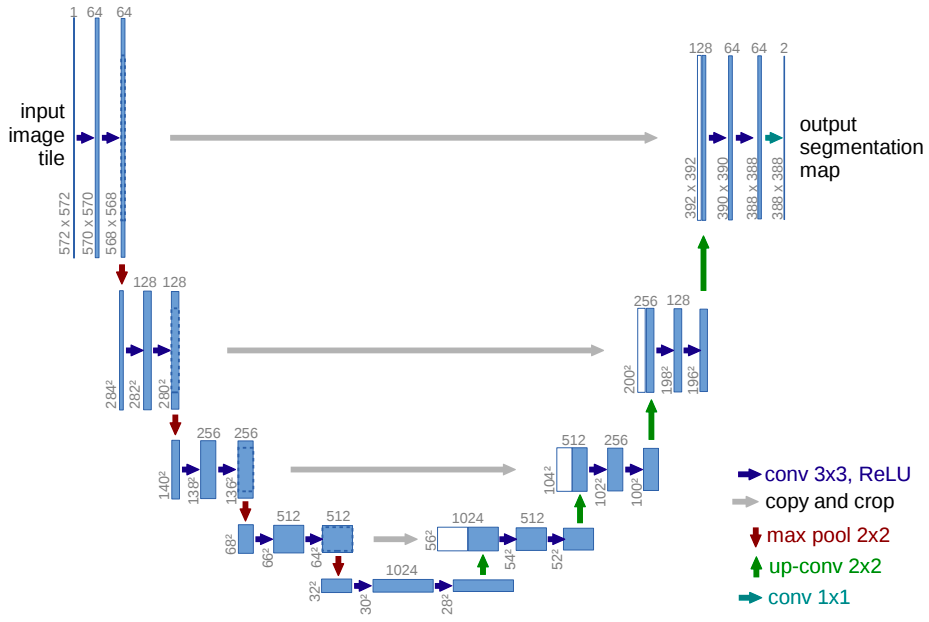

As shown in the figure, a downsampling block is composed of a series of 2 convolutions (blue arrows), followed by max pooling (red arrows). Before MaxPooling, a post-convolution tensor is saved for connections with the decoder (gray arrows). The central part - the bottleneck - applies only a series of 2 convolutions.  

A upsampling block is composed of a concatenation with convoluted outputs from the downsampling block, a double convolution layer (blue arrows) and a deconvolution layer (green arrow).

The sigmoid function is applied to the output of the last decoder block to classify each pixel into one of the classes (0 or 1).

In [13]:
def double_conv_block(inputs, n_filters):
  x = keras.layers.Conv2D(n_filters, 3, strides=(1,1), padding="same", activation="relu", kernel_initializer="he_normal")(inputs)
  x = keras.layers.Conv2D(n_filters, 3, strides=(1,1), padding="same", activation="relu", kernel_initializer="he_normal")(x)
  return x

def downsampling_block(inputs, n_filters, dropout=False, max_pooling=True):
  conv = double_conv_block(inputs,n_filters)
  if dropout == True : conv = keras.layers.Dropout(0.2)(conv)
  next_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv) if max_pooling else conv
  return next_layer, conv

In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters):
  up = keras.layers.Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(expansive_input)
  merge = keras.layers.concatenate([up, contractive_input], axis=3)
  conv = double_conv_block(merge,n_filters)
  return conv

The model is assembled with downsampling and upsampling blocks. The downsampling blocks return 2 tensors: a MaxPolling layer has been applied to the first one while the second has not. The number of downsampling block series and the initial number of filters were determined as a balance between the number of weights to be calculated and the number of features extracted.

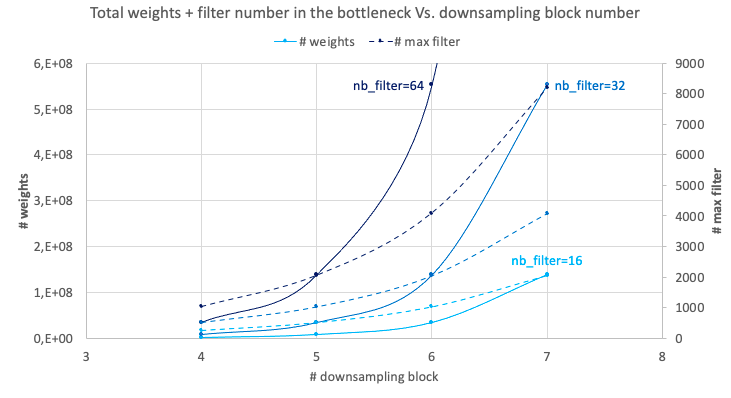

In [15]:
def create_unet_model(input_size=(256, 256, 3), n_filters=32, n_classes=1): # 1 class = pixel white = tumor area
  inputs = keras.layers.Input(input_size) # (256, 256, 3)

  # contracting path
  dblock1 = downsampling_block(inputs, n_filters) # (128, 128, 32)
  dblock2 = downsampling_block(dblock1[0], n_filters * 2) # (64, 64, 64)
  dblock3 = downsampling_block(dblock2[0], n_filters * 4) # (32, 32, 128)
  dblock4 = downsampling_block(dblock3[0], n_filters * 8) # (16, 16, 256)
  dblock5 = downsampling_block(dblock4[0], n_filters * 16) # (8, 8, 512)

  # bottleneck
  bblock6 = downsampling_block(dblock5[0], n_filters * 32, dropout=True, max_pooling=False) # (8, 8, 1024)

  # expansion path
  ublock7 = upsampling_block(bblock6[0], dblock5[1], n_filters * 16) # (16, 16, 512)
  ublock8 = upsampling_block(ublock7, dblock4[1], n_filters * 8) # (32, 32, 256)
  ublock9 = upsampling_block(ublock8, dblock3[1], n_filters * 4) # (64, 64, 128)
  ublock10 = upsampling_block(ublock9, dblock2[1], n_filters * 2) # (128, 128, 64)
  ublock11 = upsampling_block(ublock10, dblock1[1], n_filters) # (256, 256, 32)

  outputs = keras.layers.Conv2D(n_classes, 1, activation="sigmoid", padding="same")(ublock11) # (256, 256, 1)

  return keras.models.Model(inputs=inputs, outputs=outputs)

In [16]:
model = create_unet_model(n_filters=32)

### 3.2. Metric definition

Accuracy - proportion of pixels correctly classified - needs to be coupled with another metric to measure the overlap between the predicted segmentation and the true mask. This metric is called Dice coefficient and must be close to 1. In the formulation, a variable `smooth`is added to handle the case where the true mask has very few (or no) white pixels.

The function to be minimized in this model is a combination of the loss function `binary_crossentropy` and the complement of the Dice coefficient `dice_loss`. Weights have been applied to make the Dice coefficient converge more rapidly towards 1.

In [17]:
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1e-6):
  y_true_f = tf.keras.backend.flatten(y_true)
  y_pred_f = tf.keras.backend.flatten(y_pred)
  intersection = tf.keras.backend.sum(y_true_f * y_pred_f) # 2 times the area of overlap...
  return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth) # ...divided by the total number of pixels

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred) # function to minimize

@tf.keras.utils.register_keras_serializable() # 2 functions to minimize: the loss function + the complement to 1 of the dice coefficient
def combined_loss(y_true, y_pred):
  dice = dice_loss(y_true, y_pred)
  bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
  return 0.6 * dice + 0.4 * bce

In [18]:
metrics = ["accuracy", dice_coef]

initial_learning_rate = 1e-4
model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_learning_rate), loss=combined_loss, metrics=metrics)

### 3.3. Callbacks

*   `reduce_lr`: reduce learning rate by 10 (factor = 0.1) when `val_loss` has stopped improving (after 4 epochs of stagnation)
*   `stop_early`: stop the training if `val_loss` has not improved for 5 epochs.

In [19]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=1e-5,)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)

### 3.4. Training

In [20]:
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, callbacks=[stop_early, reduce_lr], **kwargs)

  return log.history

In [21]:
if device == "GPU":
  history = train_model(model, train_dataset, val_dataset, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, epochs=epochs)
  model.save('06_data_segmentation.h5', include_optimizer=False)
else:
  model = tf.keras.models.load_model('06_data_segmentation.h5', custom_objects={'combined_loss': combined_loss, 'dice_coef': dice_coef}, compile=False) # Load the model without compiling
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate), loss=combined_loss, metrics=metrics)

---


## **4. Evaluation & predictions**

### 4.1. Evaluation

In [22]:
test_loss, test_accuracy, test_coef = model.evaluate(test_dataset, steps=test_steps)
print("Test loss function value %0.2f, the test accuracy value %0.1f %% and Dice coefficient %0.2f" %(test_loss, 100*test_accuracy, test_coef))

6/6 [==============================] - 148s 22s/step - loss: 0.2610 - accuracy: 0.9711 - dice_coef: 0.6498
Test loss function value 0.26, the test accuracy value 97.1 % and Dice coefficient 0.65


Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 930, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 930 (delta 198), reused 136 (delta 136), pack-reused 698 (from 3)
Receiving objects: 100% (930/930), 198.87 MiB | 30.39 MiB/s, done.
Resolving deltas: 100% (468/468), done.


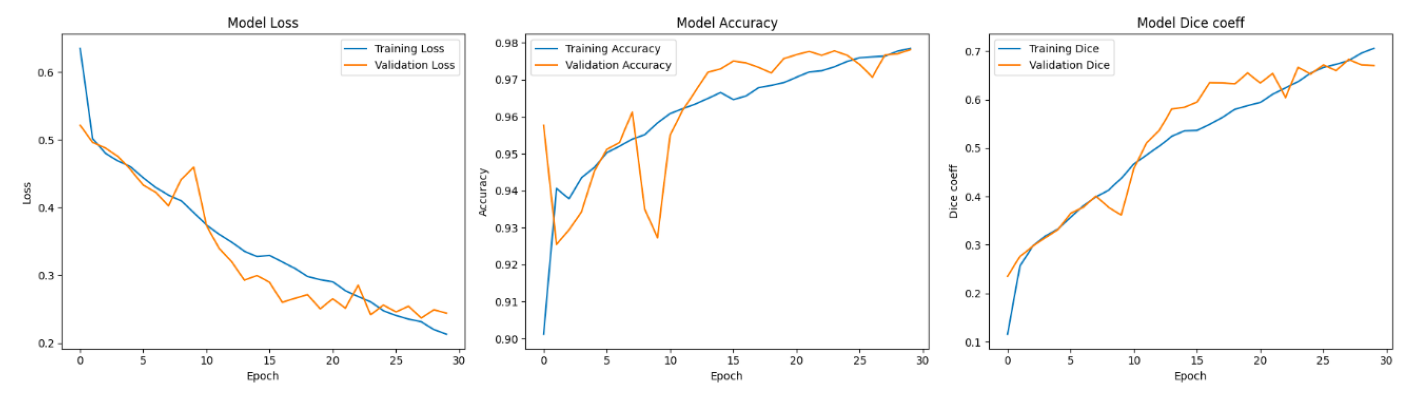

In [23]:
if device == "GPU":
  plot_evolution(history)
else:
  training_curves = get_github_files()
  plt.figure(figsize=(18, 5))
  plt.imshow(training_curves), plt.axis("off")
  plt.show()

Model accuracy is high (>97%) but the Dice coefficient remains low (<70%). The model correctly locates the global position of the tumor - explaining the high accuracy - but the precise shape of the tumor is incorrect or very approximate. Additional epochs in the training phase could further increase the Dice coefficient.

### 4.2. Predictions

1/1 [==============================] - 23s 23s/step


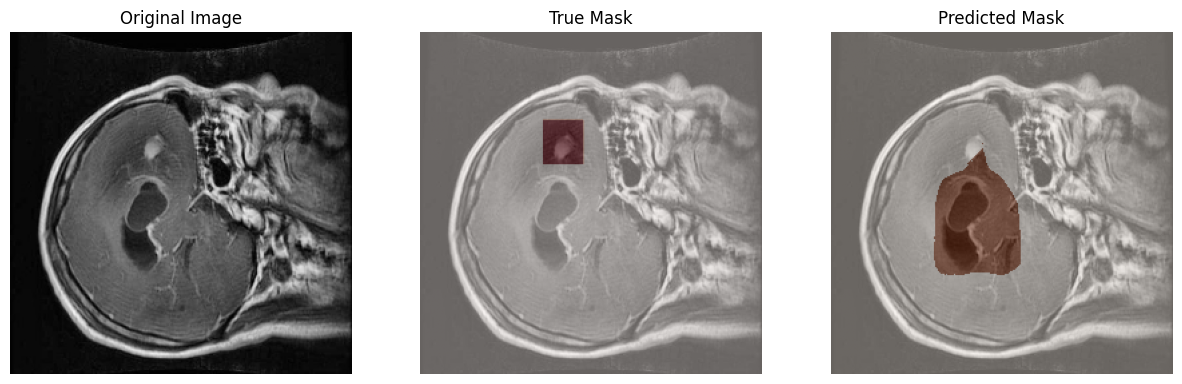

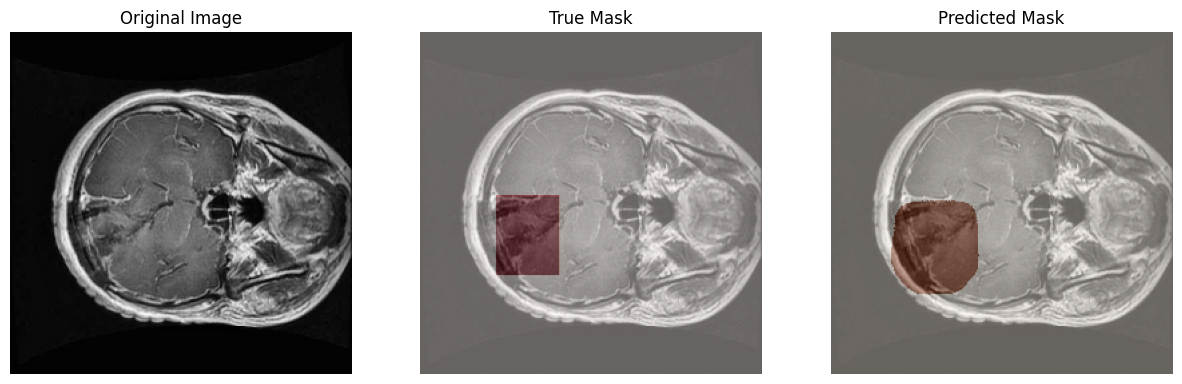

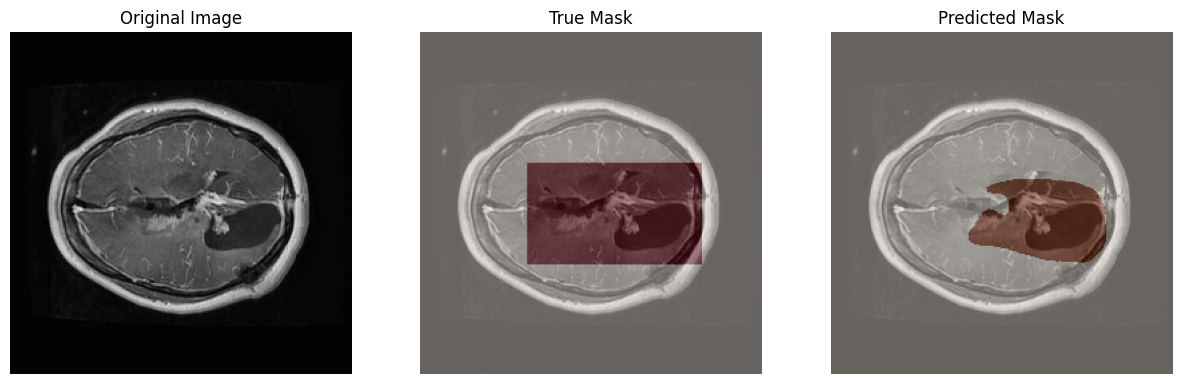

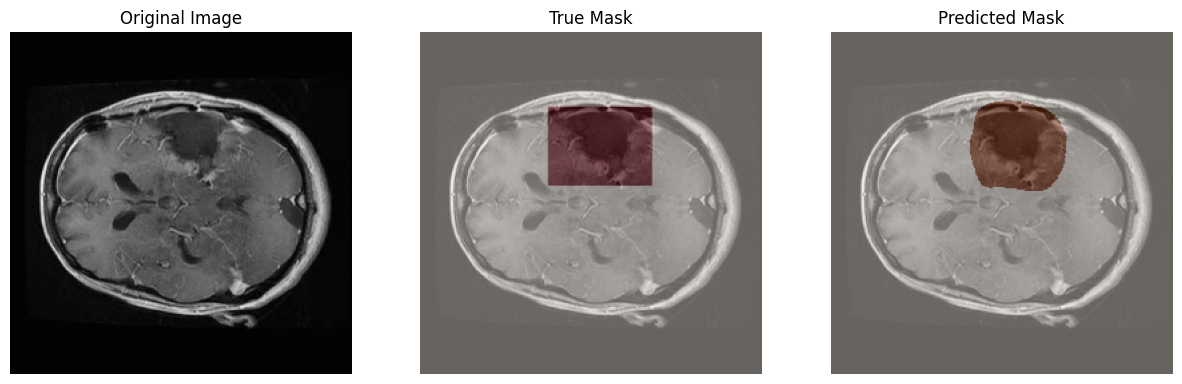

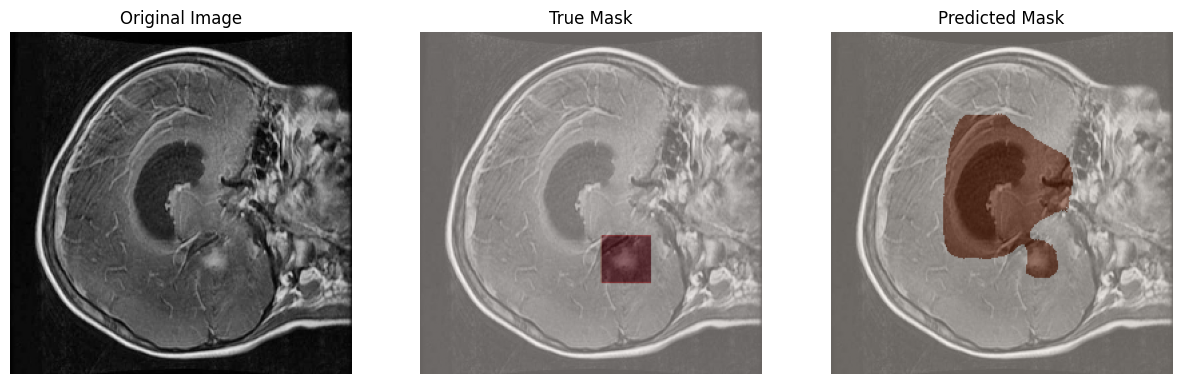

In [24]:
visualize_predictions(model, test_dataset, num_samples)

**The model developed provides correct semantic image segmentation predictions despite a limited number of epochs. [[4](https://www.sciencedirect.com/science/article/pii/S0010482523011605)] explores the possibility of rewriting a loss function by combining the Dice coefficient with cosine similarity to improve the Dice coefficient of the test set.**

---


## **5. References**

| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation) | Brain Tumor Image DataSet : Semantic Segmentation | Roboflow | dataset | - |
|[[2]](https://roboflow.com/formats/coco-json) | COCO JSON | Roboflow | tutoriels | - |
|[[3]](https://arxiv.org/pdf/1505.04597) | U-Net: Convolutional Networks for Biomedical Image Segmentation | Olaf Ronneberger and al. | paper | - |
|[[4]](https://www.sciencedirect.com/science/article/pii/S0010482523011605) | Adaptive t-vMF dice loss: An effective expansion of dice loss for medical image segmentation | Sota Kato | paper | - |
|[[5]](https://zc2256.medium.com/coco-dataset-introduction-and-simple-implementation-5e3c19c95cfe) | COCO dataset introduction and simple implementation | Medium | tutoriels | - |

In [25]:
print("Notebook run in %.1f seconds on %s" % ((time() - start), tf.config.list_physical_devices(device_type=None)[-1][-1]))

Notebook run in 200.6 seconds on CPU
